# Transfer Learning with Tensorflow Part2: Fine-tuining

Önceki bölümde, Food Vision projemizde kendi modellerimizi oluşturmaktan (daha az veriyle bile) çok daha iyi sonuçlar elde etmek için özellik çıkarma aktarım öğreniminden nasıl yararlanabileceğimizi gördük. Şimdi başka bir transfer öğrenme türünü ele alacağız: ince ayar. İnce ayarlı transfer öğreniminde, başka bir modelden önceden eğitilmiş model ağırlıkları donmaz ve kendi verilerinize daha iyi uyması için ince ayar yapılır. Özellik çıkarma aktarım öğrenimi için, önceden eğitilmiş bir modelin yalnızca en üstteki 1-3 katmanını kendi verilerinizle eğitebilirsiniz, ince ayar aktarım öğreniminde, önceden eğitilmiş bir modelin 1-3 katmanını eğitebilirsiniz (burada ' ', katmanların çoğunun veya tamamının eğitilebileceğini belirtir).

In [1]:
# Check if we're using a GPU
!nvidia-smi

Sun Jun 11 13:22:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

Yardımcı işlevler oluşturma Makine öğrenimi deneyleriniz boyunca, muhtemelen tekrar tekrar kullanmak isteyeceğiniz kod parçacıklarıyla karşılaşacaksınız. Örneğin, bir modelin geçmiş nesnesini çizen bir çizim işlevi (aşağıdaki plot_loss_curves()'a bakın). Bu işlevleri defalarca yeniden oluşturabilirsiniz. Ancak tahmin edebileceğiniz gibi, aynı işlevleri yeniden yazmak sıkıcı hale geliyor. Çözümlerden biri, bunları helper_functions.py gibi bir yardımcı komut dosyasında depolamaktır. Ardından, ihtiyacınız olduğunda gerekli işlevselliği içe aktarın. Örneğin, şunu yazabilirsiniz: from helper_functions import plot_loss_curves


In [2]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py # daha önce yazıgımız işmizi yarar fonksiyonların tamamınını kulanabileceğiz

--2023-06-11 13:22:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-11 13:22:47 (62.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir# daha önce yazdığımız yardımcı fonksiyonları kullanmak için içeri aktardık

🔑Not: Bu not defterini Google Colab'da çalıştırıyorsanız, zaman aşımına uğradığında Colab helper_functions.py dosyasını siler. Dolayısıyla, yukarıda içe aktarılan işlevleri kullanmak için hücreyi yeniden çalıştırmanız gerekir.

# Let's get some data
This time we're going to see how we can use the prertrained

models within tf.keras.applications

Bu sefer önceden eğitilmiş modeleri t.keras.application şeklinde kullanımını göreceğiz

Link:https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2023-06-11 13:22:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 209.85.200.128, 209.85.234.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   194MB/s    in 0.8s    

2023-06-11 13:22:52 (194 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [6]:
# Create training and test directories 
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Şimdi bazı görüntü verilerimiz var, onu TensorFlow uyumlu bir formata yüklemenin bir yoluna ihtiyacımız var. Daha önce ImageDataGenerator sınıfını kullandık. Bu iyi çalışıyor ve hala yaygın olarak kullanılıyor olsa da, bu kez image_data_from_directory işlevini kullanacağız. ImageDataGenerator'ın flow_from_directory yöntemiyle hemen hemen aynı şekilde çalışır, yani resimlerinizin aşağıdaki dosya biçiminde olması gerekir:


10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    

ImageDataGenerator yerine tf.keras.prepreprocessing.image_dataset_from_directory() kullanmanın ana faydalarından biri, bir oluşturucu yerine bir tf.data.Dataset nesnesi oluşturmasıdır. Bunun ana avantajı, tf.data.Dataset API'sinin daha büyük veri kümeleri için çok önemli olan ImageDataGenerator API'sinden çok daha verimli (daha hızlı) olmasıdır.

In [7]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")                                                                     

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


* directory - the filepath of the target directory we're loading images in from.

* image_size - the target size of the images we're going to load in (height, width).

* batch_size - the batch size of the images we're going to load in. For example if the batch_size is 32 (the default), batches of 32 images and labels at a time will be passed to the model.

In [8]:
for images,labels in train_data_10_percent:
  print(images.shape)
  print(labels.shape)

(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(32, 224, 224, 3)
(32, 10)
(14, 224, 224, 3)
(14, 10)


In [9]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example batch of data
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[1.02409119e+02 9.27617950e+01 9.33992290e+00]
   [1.14906578e+02 1.06233742e+02 2.28412533e+00]
   [1.86188782e+02 1.78188782e+02 4.73182411e+01]
   ...
   [1.28049088e+02 1.01049080e+02 9.40490799e+01]
   [1.25401741e+02 9.84017410e+01 9.14017410e+01]
   [1.21991035e+02 9.29910355e+01 8.69910355e+01]]

  [[8.71336136e+01 7.85073318e+01 7.07429838e+00]
   [1.08700577e+02 9.97720032e+01 2.14732647e+00]
   [1.78863205e+02 1.69225769e+02 4.01626282e+01]
   ...
   [1.34329346e+02 1.07329353e+02 1.00329353e+02]
   [1.30031189e+02 1.03031189e+02 9.60311890e+01]
   [1.28537277e+02 9.95372772e+01 9.35372772e+01]]

  [[7.55934296e+01 6.68077164e+01 1.09582281e+01]
   [8.45076599e+01 7.42353439e+01 1.92761934e+00]
   [1.73779663e+02 1.62074615e+02 4.18842468e+01]
   ...
   [1.37955307e+02 1.09955307e+02 1.06169594e+02]
   [1.33602615e+02 1.05602615e+02 1.01816902e+02]
   [1.32781235e+02 1.03566948e+02 9.99955215e+01]]

  ...

  [[2.04058319e+02 1.73486847e+02 1.29210022e+02]
   [2

# Model 0: Building a transfer learning model using the Keras Functional API


Pekala, verilerimiz tensörlü, hadi bir model oluşturalım. Bunu yapmak için, tf.keras.applications modülünü kullanacağız çünkü bu modül, önceden eğitilmiş (ImageNet üzerinde) bir dizi bilgisayar görme modeli ve modelimizi oluşturmak için Keras İşlevsel API'sini içeriyor. Aşağıdaki adımlardan geçeceğiz: tf.keras.applications'tan EfficientNetB0 gibi bir hedef model seçerek, include_top parametresini False olarak ayarlayarak önceden eğitilmiş bir temel model nesnesinin örneğini oluşturun (bunu yapıyoruz çünkü modelin çıktı katmanları olan kendi üstümüzü oluşturun). Önceden eğitilmiş modeldeki tüm ağırlıkları dondurmak için temel modelin eğitilebilir özniteliğini Yanlış olarak ayarlayın. Modelimiz için bir girdi katmanı tanımlayın, örneğin, modelimiz hangi veri şeklini beklemelidir? [İsteğe bağlı] Gerekiyorsa modelimizin girdilerini normalleştirin. ResNetV250 gibi bazı bilgisayarla görme modelleri, girdilerinin 0 ve 1 arasında olmasını gerektirir.

Keras, derin öğrenme modellerini oluşturmak için kullanılan popüler bir Python kütüphanesidir. Keras'ın iki farklı API'si vardır: Sequential API ve Functional API.

Sequential API, basit ve sıralı derin öğrenme modellerini oluşturmak için kullanılır. Bu API, katmanları ardışık olarak ekleyerek modeli tanımlamanıza olanak sağlar. Bu API, giriş verilerinin tek bir yola girdiği ve çıktının da tek bir yoldan çıktığı düz modellerin oluşturulması için uygundur. Örneğin, bir sinir ağı modelinde giriş katmanını ardışık olarak eklemek, ardından gizli katmanları ve çıkış katmanını eklemek için Sequential API'yi kullanabilirsiniz. Sequential API, basit yapıya sahip modellerin hızlı bir şekilde oluşturulmasını sağlar ve başlangıç düzeyindeki kullanıcılar için daha kullanımı kolaydır.

Functional API, daha karmaşık ve esnek derin öğrenme modellerinin oluşturulması için kullanılır. Bu API, katmanları daha esnek bir şekilde bağlamanıza ve modelleri oluşturmanıza olanak sağlar. Functional API, birden fazla giriş ve çıkışa sahip modellerin, paylaşılan katmanların, dallanan modellerin ve daha karmaşık yapıların oluşturulmasını destekler. Ayrıca, Functional API ile modelin içinde döngüler ve koşullu ifadeler gibi daha fazla kontrol akışı özelliklerini de kullanabilirsiniz. Functional API, daha fazla esneklik ve özelleştirme imkanı sağladığından, daha karmaşık ve özelleştirilmiş modeller geliştirmek isteyen kullanıcılar için uygundur.

Özetlemek gerekirse, Sequential API basit ve ardışık modellerin oluşturulmasında kullanılırken, Functional API daha karmaşık ve esnek modellerin oluşturulmasına olanak sağlar. Hangi API'nin kullanılacağı, modelin karmaşıklığına ve ihtiyaçlara bağlıdır.

In [12]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # inculude_top = False bu parametre kulanıldığında önceden eğitilmiş modelin sonundaki tamamen bağlı (fully connected) katmanlarını dahil etmez
# include_top=False parametresi kullanılarak önceden eğitilmiş bir modelin çıktısını almak, genellikle çıkış katmanı yerine bu çıktıyı başka bir modelin girişine veya bir sınıflandırıcıya bağlamak için kullanılır. Böylece, önceden eğitilmiş modelin özellik çıkarım yetenekleri korunurken, yeni bir görev için sınıflandırma 
#veya regresyon gibi özel bir çıktı katmanı ekleyebilirsiniz.
# Kısaca include_top=False modelin çıktı katmanını değiştirmek ve özeleştirmek için kullanırız
# 2. Freeze the base model ()
base_model.trainable = False # önceden öğrenilmiş desenler korunur ve ağırlıklar güncellenmez
# Bu kodu kullanarak, önceden eğitilmiş modelin özellik çıkarım yeteneklerini korurken, sadece üzerine eklediğiniz özel çıktı katmanını eğitebilirsiniz. Önceden eğitilmiş modelin ağırlıklarını
# dondurmak, daha az veriyle veya sınırlı bir veri setiyle çalışırken overfitting'i önlemek veya hesaplama kaynaklarını korumak için faydalı olabilir.
# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # modelin giriş katmanını oluşturuyoruz
# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)# burada ise datamızı normalize ediyoruz
# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized) EfficientNetB0 kullanmak için datanın normalize edilmesi gerekmez
x = base_model(inputs)# Girişleri temel modele iletiyoruz
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) # Temelein model çıktıklarını havuzlama katmanından geçiriyoruz Bu işlem modelin daha yüksek seviyeli özelileri öğrenmesine yardımcı olur
print(f"After GlobalAveragePooling2D(): {x.shape}")
# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)# Aktivasyon katmanı oluşturuyoruz

# 8. Combine the inputs with the outputs into a model girdiler ile çıktıları bir modelde birleştirirerek tam bir model oluşturuyoruz
model_0 = tf.keras.Model(inputs, outputs)# Giriş ve çıkışları birleştirerek tam bir model oluşturuyoruz ve modelin tamamı model_0 değişkeninine atanmış olur
# 9.Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

16705208/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20230611-132311


Epoch 1/5
24/24 [==============================] - 25s 280ms/step - loss: 1.8834 - accuracy: 0.4107 - val_loss: 1.2738 - val_accuracy: 0.7533
Epoch 2/5
24/24 [==============================] - 4s 138ms/step - loss: 1.0975 - accuracy: 0.7693 - val_loss: 0.8596 - val_accuracy: 0.8372
Epoch 3/5
24/24 [==============================] - 5s 177ms/step - loss: 0.7938 - accuracy: 0.8173 - val_loss: 0.6928 - val_accuracy: 0.8569
Epoch 4/5
24/24 [==============================] - 5s 185ms/step - loss: 0.6438 - accuracy: 0.8547 - val_loss: 0.5898 - val_accuracy: 0.8766
Epoch 5/5
24/24 [==============================] - 5s 179ms/step - loss: 0.5433 - accuracy: 0.8720 - val_loss: 0.5186 - val_accuracy: 0.8849


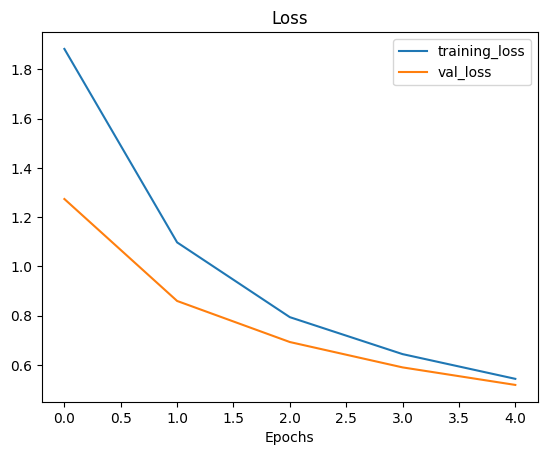

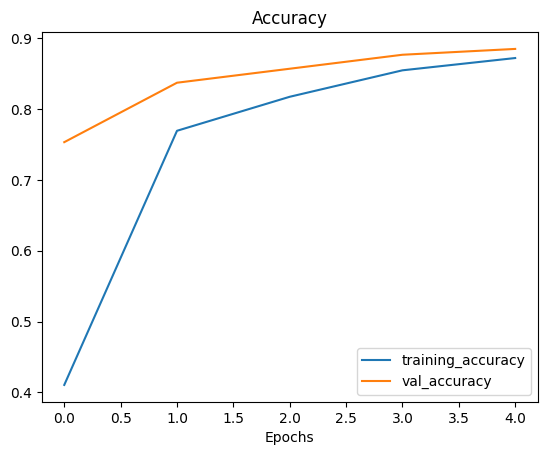

In [13]:
plot_loss_curves(history_10_percent)

In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [15]:
# Evaluate on the full test dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 7s 78ms/step - loss: 0.5512 - accuracy: 0.8596


[0.5512070059776306, 0.8596000075340271]

In [16]:
# Check the layers in our base model
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [17]:
# How about we get a summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [18]:
# How about a summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Getting a feature vector from trained model
🤔 Soru: tf.keras.layers.GlobalAveragePooling2D() katmanına ne olur? Daha önce görmedim. tf.keras.layers.GlobalAveragePooling2D() katmanı, iç eksenlerdeki değerlerin ortalamasını alarak 4B tensörü 2B tensöre dönüştürür. Önceki cümle biraz ağız dolusu, o yüzden bir örnek görelim.

In [19]:
# Define the input shape
input_shape=(1,4,4,3)
# Create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")
# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n")

# Check the shape of the diffrerent tensors 
print(f"Shape of input tensor:{input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor:{global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor:(1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor:(1, 3)


GlobalAveragePooling2D, derin öğrenme modellerinde yaygın olarak kullanılan bir katman türüdür. Bu katman, evrişimli sinir ağları (Convolutional Neural Networks - CNN) veya benzeri yapılarla birlikte kullanılır.

Convolutional layerlar, bir görüntü veya başka bir girdi üzerinde evrişim işlemlerini gerçekleştirir ve özellik haritalarını çıkarır. Bu özellik haritaları, özgün girdiye dair farklı özniteliklerin temsilini içerir. Örneğin, bir CNN, bir görüntüdeki köşeleri, kenarları veya diğer dikkate değer özellikleri tanımak için bu özellik haritalarını kullanabilir.

GlobalAveragePooling2D katmanı, bu özellik haritalarını sıkıştırarak ve özniteliklerin ortalamasını alarak işlem yapar. Katman, özellik haritalarının boyutunu düşürür ve her bir özellik haritası için bir sayısal özetleme yapar. Bu, ağın çeşitli özelliklerin ortalamasını almasını sağlar ve böylece daha genel bir temsili elde eder.

GlobalAveragePooling2D katmanının en önemli avantajlarından biri, CNN'nin daha az parametre içermesini sağlamasıdır. Bununla birlikte, ağın daha az ağırlık içermesi, modelin genelleştirme yeteneğini artırabilir ve aşırı uyum (overfitting) riskini azaltabilir. Ayrıca, GlobalAveragePooling2D, tüm özellik haritalarını bir araya getirerek, girdi boyutundan bağımsız bir çıktı üretir. Bu da farklı boyutlardaki girdilerle çalışmayı kolaylaştırır.

Sonuç olarak, GlobalAveragePooling2D katmanı, CNN tabanlı modelin özellik haritalarını sıkıştırır ve daha genel bir temsil elde etmek için ortalamalarını alır. Bu, sınıflandırma, nesne tespiti veya diğer görsel görevler gibi derin öğrenme uygulamalarında yaygın olarak kullanılan bir yöntemdir.

In [20]:
# Let's replicate the GlobalAveragePooling2D layer 
tf.reduce_mean(input_tensor,axis=[1,2])
# tf.reduce_mean(input_tensor, axis=[1,2]) kodu, TensorFlow kütüphanesindeki bir fonksiyonu kullanarak, verilen input_tensor tensörünün belirtilen eksenlere (1 ve 2) göre ortalama değerini hesaplar.

# input_tensor bir tensörü temsil eder ve bu tensörün boyutları genellikle 4-boyutlu bir tensördür: [batch_size, height, width, channels]. Bu tensör genellikle bir CNN'in çıktılarından biridir, 
# yani özellik haritalarını içerir.

# axis=[1,2] ifadesi, hesaplamanın ortalama değerlerin alınacağı eksenleri belirtir. Yani, 1. ve 2. eksenlerdeki değerlerin ortalaması alınır. Bu durumda, genellikle yükseklik (height) ve genişlik (width) 
# eksenleridir. Bu, her bir özellik haritası için bir ortalama değer üretir.

# Sonuç olarak, bu kod, özellik haritalarının yükseklik ve genişlik boyutlarına göre ortalamasını alır. Bu, özellik haritalarını daha küçük bir boyuta sıkıştırmak ve daha genel bir temsil elde etmek için kullanılabilir. 
# Özellikle, CNN tabanlı modellerde, özellik haritalarının boyutunu düşürmek ve ağın daha az parametre içermesini sağlamak için sıklıkla kullanılan bir işlemdir.
# GlobalAveragePooling2D özelik vektörü elde etmek için kullanılan bir yöntemdir yani modelimizin bir görüntüde öğrendiği özelikleri çıkarmak için kullanırız

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

GlobalMaxPool2D ve GlobalAveragePooling2D arasındaki fark, özellik haritalarının özetlenme yöntemlerinde yatmaktadır.

GlobalMaxPool2D, bir CNN tabanlı modeldeki özellik haritalarını sıkıştırmak ve en büyük değerlerini seçmek için kullanılır. Yani, her bir özellik haritası için en yüksek değeri alarak özniteliklerin özetini oluşturur. Bu, her bir özellik haritasında en belirgin özelliğin temsilini sağlar. Örneğin, bir özellik haritası köşeleri, kenarları veya diğer önemli özellikleri içeriyorsa, GlobalMaxPool2D en belirgin olanı seçecektir.

Öte yandan, GlobalAveragePooling2D, özellik haritalarını sıkıştırırken özellik değerlerinin ortalamasını alır. Her bir özellik haritasındaki özniteliklerin ortalaması ile özelliklerin genel bir temsilini elde eder. Bu, özellik haritalarının daha yumuşak bir özetini sağlar ve daha az vurgulanan özelliklere de dikkat eder.

Genel olarak, GlobalMaxPool2D en belirgin özelliği vurgularken, GlobalAveragePooling2D daha genel bir temsil sağlar. Hangi yöntemi kullanmanız gerektiği, veri seti ve hedef görevinizin doğasına bağlı olacaktır. Bazı durumlarda, daha belirgin özelliklerin önemli olduğu durumlarda GlobalMaxPool2D tercih edilirken, diğer durumlarda GlobalAveragePooling2D tercih edilebilir.

# What is a feature vector

* Özelik vektörü giriş verilerinin sıkıştırılmış bir formu olan verilerin öğrenilmiş bir temsilidir

# Running a series of transfer learning experiments
We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:

* model_1: Use feature extraction transfer learning on 1% of the training data with data augmentation.

* model_2: Use feature extraction transfer learning on 10% of the training data with data augmentation.

* model_3: Use fine-tuning transfer learning on 10% of the training data with data augmentation.

* model_4: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

### Getting and preprocessing data for model_1

In [21]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip") 

--2023-06-11 13:24:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.161.128, 74.125.126.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.161.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  93.1MB/s    in 1.4s    

2023-06-11 13:24:11 (93.1 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [22]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [23]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'

In [24]:
# Setup data loaders
IMG_SIZE=(224,224)
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                         label_mode='categorical',
                                                                         image_size=IMG_SIZE,
                                                                         batch_size=32)# default = 32
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                         label_mode='categorical',
                                                                         image_size=IMG_SIZE,
                                                                         batch_size=32)# default = 32

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

Veri büyütmeyi doğrudan modelerimize içindeki katmanlarda  kullanabiliriz 

* tf.keras.layers.experimental.preprocessing()

# To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

If that sounds confusing, it'll make sense once we create it in code.

The data augmentation transformations we're going to use are:

* RandomFlip - flips image on horizontal or vertical axis.

* RandomRotation - randomly rotates image by a specified amount.

* RandomZoom - randomly zooms into an image by specified amount.

* RandomHeight - randomly shifts image height by a specified amount.

* RandomWidth - randomly shifts image width by a specified amount.

* Rescaling - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using the tf.keras.applications implementation of EfficientNetB0, it's not required.
There are more option but these will do for now.

* https://www.tensorflow.org/tutorials/images/data_augmentation?hl=tr

* Gorüntü verisi büyütme sadece eğitim veri kümesinde gerçekleşir

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing 

# Create data augmentation stage with horizontal flipping,rotations,zooms,etc
data_augmentation=keras.Sequential([# Resimleri yeniden şeklindirme için kulandığımız yöntemdir overfitingi önlemeye yardımcı olur öğrenmeyi zorlaştırır
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255) # ResNet50V2 gibi modelerde bu işlem gerekli olacaktır EfficientNet modelinde yeniden ölçeklendirmemize grek yoktur
],name='data_augmentation')

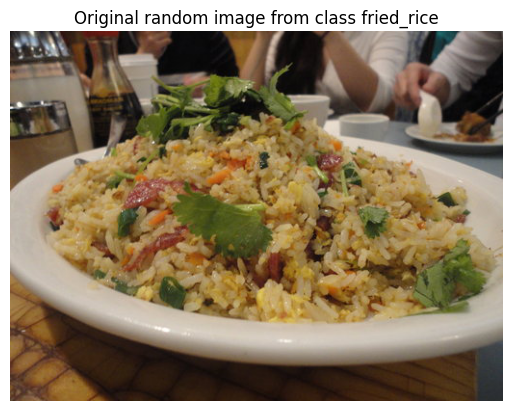

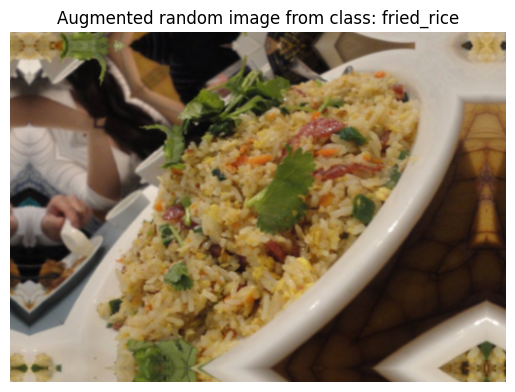

In [26]:
### View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
# Read  and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [27]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

# Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [28]:
# Setup input shape and base model freezing  the base model layers
input_shape=(224,224,3)
bese_model = tf.keras.applications.EfficientNetB0(include_top=False)# include_top=False çıktı katmanını değiştirmek özeleştirmek için kulanırız burada ayrıca base bir model oluşturuyoruz
base_model.trainable=False # önceden öğrenilmiş desenler korunur
# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")# Girdi katmanı oluşturduk

# Add in data augmentation Sequential model as a layer katman olarak data_augmentation katmanını ekledik
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it base_model girdileri verin (arttırmadan sonra) ve onu eğitmeyin
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)# girdileri havuzlama katmanından geçirerek çıktı elde edilir

# Put a dense layer on as the output
outputs = layers.Dense(10,activation='softmax',name='output_layer')(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs,outputs)# Girdi ve çıktı katmanlarını birleştiriyoruz

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230611-132418
Epoch 1/5
3/3 [==============================] - 13s 2s/step - loss: 2.3460 - accuracy: 0.0571 - val_loss: 2.1364 - val_accuracy: 0.2303
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.0564 - accuracy: 0.3714 - val_loss: 2.0300 - val_accuracy: 0.3306
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.8896 - accuracy: 0.4857 - val_loss: 1.9293 - val_accuracy: 0.3783
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.6501 - accuracy: 0.6571 - val_loss: 1.8256 - val_accuracy: 0.4523
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5452 - accuracy: 0.7429 - val_loss: 1.7223 - val_accuracy: 0.5247


In [29]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [30]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 93ms/step - loss: 1.7193 - accuracy: 0.5340


[1.719275951385498, 0.5339999794960022]

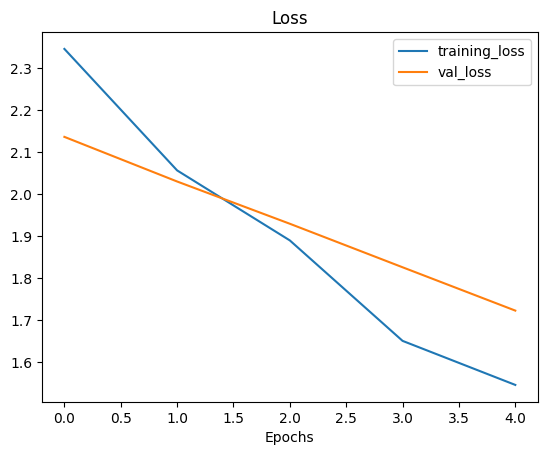

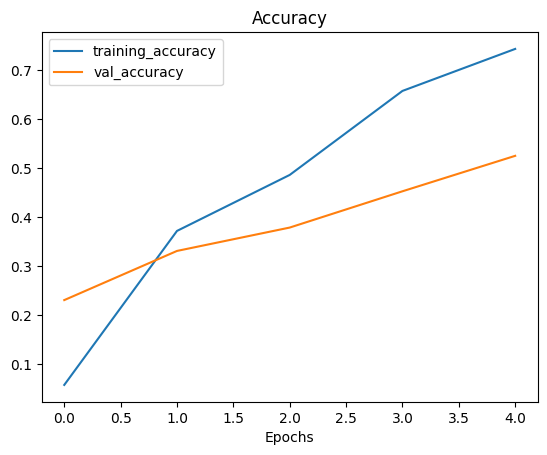

In [31]:
# How does the model go with data augmentation Layer with 1% of data
plot_loss_curves(history_1_percent)

# Model 2: Feature extraction transfer learning with 10% of data and data augmentation


In [32]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

--2023-06-11 13:24:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 74.125.201.128, 74.125.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   174MB/s    in 0.9s    

2023-06-11 13:25:00 (174 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [33]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [34]:
from keras.layers.serialization import activation
# Create a functional model with data augmentation
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

# Setup the input shape your model
input_shape=(224,224,3)
# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False) # include_top = False parametresi çıktı katmanını özeliştirmek değiştirmek için kullanılır 
base_model.trainable = False # modelin önceden öğrendi kalıplar korunur

# Create input and aoutput layers
inputs = layers.Input(shape=input_shape,name='input_layer') # create input Layer girdi katmanı 
x = data_augmentation(inputs) # veri artırma katmanını ekledik 
x = base_model(x,training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x) # havuzlama katmanı 
outputs = layers.Dense(10,activation='softmax',name='output_layer')(x) # Çıktı katmanı 
model_2 = tf.keras.Model(inputs,outputs)
# Compile 
model_2.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])

### ModelCheckpoint geri araması oluşturma 
Modelimiz derlendi ve sığdırılmaya hazır, öyleyse neden henüz sığdıramadık? Pekala, bu deney için yeni bir geri aramayı tanıtacağız, ModelCheckpoint geri araması. ModelCheckpoint geri araması, modelinizi bir bütün olarak SavedModel biçiminde veya ağırlıkları (kalıpları) eğitirken yalnızca belirli bir dizine kaydetme olanağı sağlar. Bu, modelinizin uzun süre eğitim alacağını düşünüyorsanız ve eğitirken onun yedeğini almak istiyorsanız yararlıdır. Ayrıca, modelinizin daha uzun süre eğitilmekten fayda sağlayabileceğini düşünüyorsanız, onu belirli bir kontrol noktasından yeniden yükleyebilir ve eğitime buradan devam edebilirsiniz. Örneğin, 5 dönem için bir özellik çıkarma aktarım öğrenme modeline uyduğunuzu ve eğitim eğrilerini kontrol ettiğinizi ve bunun hala gelişmekte olduğunu gördüğünüzü ve başka bir 5 dönem için ince ayarın yardımcı olup olmayacağını görmek istediğinizi varsayalım, kontrol noktasını yükleyebilir, donmayı çözebilirsiniz. temel model katmanlarından bazıları (veya tümü) ve ardından eğitime devam edin. Aslında, tam olarak yapacağımız şey bu. Ama önce, bir ModelCheckpoint geri araması oluşturalım. Bunu yapmak için, kaydetmek istediğimiz bir dizini belirlememiz gerekiyor.

In [35]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [36]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230611-132507
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9454 - accuracy: 0.3760
Epoch 1: val_loss improved from inf to 1.38193, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 24s 650ms/step - loss: 1.9454 - accuracy: 0.3760 - val_loss: 1.3819 - val_accuracy: 0.6628
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2776 - accuracy: 0.6920
Epoch 2: val_loss improved from 1.38193 to 0.94437, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 577ms/step - loss: 1.2776 - accuracy: 0.6920 - val_loss: 0.9444 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9806 - accuracy: 0.7627
Epoch 3: val_loss improved from 0.94437 to 0.75189, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=

In [37]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 70ms/step - loss: 0.6103 - accuracy: 0.8464


[0.6102545261383057, 0.8464000225067139]

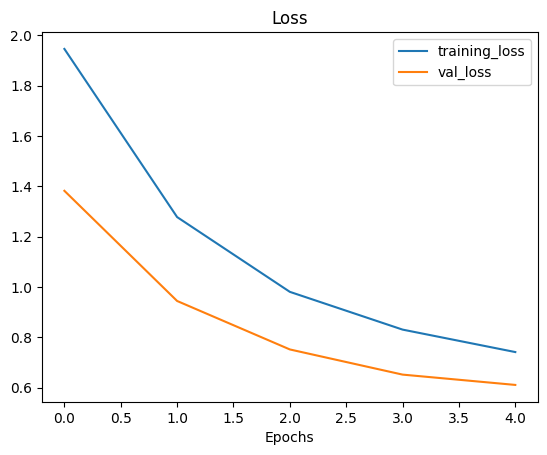

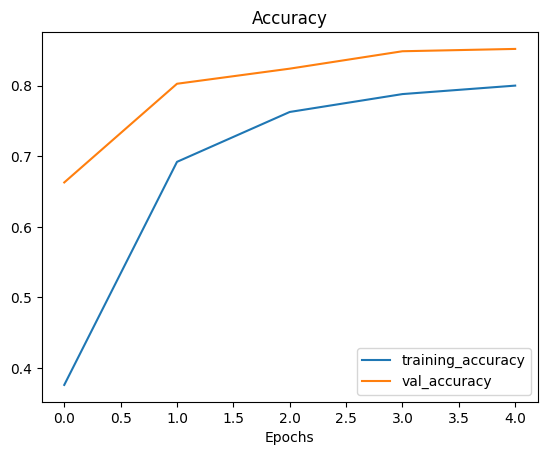

In [38]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

Transfer öğrenmede, özellik çıkarma katmanı genellikle bir ön-eksinlik olarak kullanılır. Bu, önceden eğitilmiş modelin son katmanlarının çıkarıldığı ve yeni görev için uygun sınıflandırma veya regresyon katmanlarının eklenerek yeniden eğitildiği anlamına gelir. Bu şekilde, özellik çıkarma katmanı, yeni görevin gerektirdiği özellikleri yakalamak için kullanılırken, sınıflandırma veya regresyon katmanları, yeni görevin özel gereksinimlerine uyacak şekilde ayarlanır.

Özetlemek gerekirse, özellik çıkarma katmanı, transfer öğrenme sürecinde önceden eğitilmiş bir modelin bir parçası olarak kullanılan ve verilerden anlamlı özelliklerin çıkarılmasını sağlayan bir katmandır. Bu özellikler, yeni görevde daha iyi performans göstermek için kullanılan daha ileri katmanlarla birlikte kullanılır.

Özellik çıkarıcı katman, genellikle derin sinir ağı mimarilerinde "Convolutional Neural Network" (CNN) olarak bilinen katmanlardır. CNN'ler, görsel verilerdeki özellikleri tanımak için yaygın olarak kullanılan ve genellikle önceden eğitilmiş modeller olarak temin edilen ağırlıklara sahip katmanlardır.

CNN'ler, konvolüsyon (convolution), aktivasyon ve havuzlama (pooling) gibi işlemleri bir araya getiren bir dizi katmandan oluşur. Bu katmanlar, giriş verilerini filtrelerle işleyerek, verilerden önemli özellikleri çıkarmaya odaklanır. Bu sayede, özellik çıkarıcı katmanlar, görsel verilerdeki yüksek seviyeli özellikleri yakalamak için önceden eğitilmiş ağırlıkları kullanır.

### Loading in checkpointed

Loading in checkpointed weights returns a model to a specific checkpoint 

In [39]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.6103 - accuracy: 0.8464


In [40]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

False

In [41]:
results_10_percent_data_aug

[0.6102545261383057, 0.8464000225067139]

In [42]:
loaded_weights_model_results

[0.6102544665336609, 0.8464000225067139]

In [43]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

## Model 3: Fine-tuning an existing model on 10% of the data

Bir EfficientNet modeline ince ayar yapmanın üst düzey örneği. Eğitim sırasında üst katmanlar (çıktı verilerine daha yakın katmanlar) güncellenirken, alt katmanlar (giriş verilerine daha yakın katmanlar) donmuş halde kalır.

Şimdiye kadar kaydedilen modelimiz, eğitim verilerinin %10'unda 5 dönem için özellik çıkarma aktarım öğrenmesi ve veri artırma kullanılarak eğitildi.

Bu, eğitim sırasında temel modeldeki (EfficientNetB0) tüm katmanların dondurulduğu anlamına gelir.

Bir sonraki deneyimiz için, ince ayarlı aktarım öğrenimine geçeceğiz. Bu, bazı katmanlarını (en üste en yakın olanları) çözeceğimiz ve modeli birkaç dönem daha çalıştıracağımız dışında aynı temel modeli kullanacağımız anlamına gelir.

İnce ayar fikri, önceden eğitilmiş modeli kendi verilerimize göre özelleştirmeye başlamaktır.

🔑 Not: İnce ayar genellikle bir özellik çıkarma modelini birkaç dönem için ve büyük miktarda veriyle eğittikten sonra en iyi sonucu verir. Bu konuda daha fazla bilgi için Keras'ın Transfer öğrenimi ve ince ayar kılavuzuna göz atın.

Yüklü modelimizin performansını doğruladık, şimdi katmanını kontrol

In [44]:
# Layers in Loaded model
model_2.layers

In [45]:
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f3530251a80> True
<keras.engine.sequential.Sequential object at 0x7f34b14a27d0> True
<keras.engine.functional.Functional object at 0x7f34aa6f5f30> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f354c4d2e00> True
<keras.layers.core.dense.Dense object at 0x7f35303721a0> True


İyi görünüyor. Bir giriş katmanımız, bir Sıralı katmanımız (veri büyütme modeli), bir İşlevsel katmanımız (EfficientNetB0), bir havuzlama katmanımız ve bir Yoğun katmanımız (çıktı katmanı) var. Bir özete ne dersiniz?

In [46]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

Alright, it looks like all of the layers in the efficientnetb0 layer are frozen. We can confirm this using the trainable_variables attribute

In [47]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [48]:
# How many trainable varialbes are in our base model # Eğitilbilir değişken güncelenen ağırlık veya desendir
print(len(model_2.layers[2].trainable_variables))

0


In [49]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable=True
base_model.trainable=True
# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:# son 10 katman hariç diğer katmanları dondurduk
  layer.trainable=False
# Recompile (we have recompile our models every ime we make a chenge) # Her değişiklik yaptığımızda modelerimzizi yeniden derlememiz gerekiyor
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),# ince ayar yaparken genelkle learning_rate azaltmak isteriz overfiten kaçmak için
                metrics=['accuracy'])
# base_model de günceleme yapmak otomatik olarak model_2 de de günceleme yaptığımız anlamına geliyor çünkü mode_2 bir transfer öğrenme modelidir

In [50]:
for layer in base_model.layers[:-10]:
  print(layer.name)

input_3
rescaling_4
normalization_2
rescaling_5
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand

In [51]:
# Check which layers are tunable (trainable)
for layer_number,layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable) # Buradadnda görüldüğü üzere son 10 katman eğitilebilir

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [52]:
# How many trainable veriables are there
print(len(model_2.trainable_variables))

12


In [53]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [54]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch yani eğitimi 5. den başlayacak
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) 

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230611-132647
Epoch 5/10
24/24 [==============================] - 24s 527ms/step - loss: 0.6960 - accuracy: 0.7747 - val_loss: 0.5069 - val_accuracy: 0.8273
Epoch 6/10
24/24 [==============================] - 10s 407ms/step - loss: 0.3529 - accuracy: 0.9040 - val_loss: 0.4030 - val_accuracy: 0.8750
Epoch 7/10
24/24 [==============================] - 9s 378ms/step - loss: 0.1987 - accuracy: 0.9320 - val_loss: 0.3727 - val_accuracy: 0.8651
Epoch 8/10
24/24 [==============================] - 10s 406ms/step - loss: 0.1382 - accuracy: 0.9600 - val_loss: 0.4178 - val_accuracy: 0.8816
Epoch 9/10
24/24 [==============================] - 11s 420ms/step - loss: 0.0984 - accuracy: 0.9760 - val_loss: 0.4022 - val_accuracy: 0.8882
Epoch 10/10
24/24 [==============================] - 11s 403ms/step - loss: 0.0754 - accuracy: 0.9787 - val_loss: 0.3854 - val_accuracy: 0.8964


In [55]:
# Evaluate the fine-tuned model (model)
result_fine_tune_10_percent=model_2.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.4705 - accuracy: 0.8644


In [56]:
results_10_percent_data_aug

[0.6102545261383057, 0.8464000225067139]

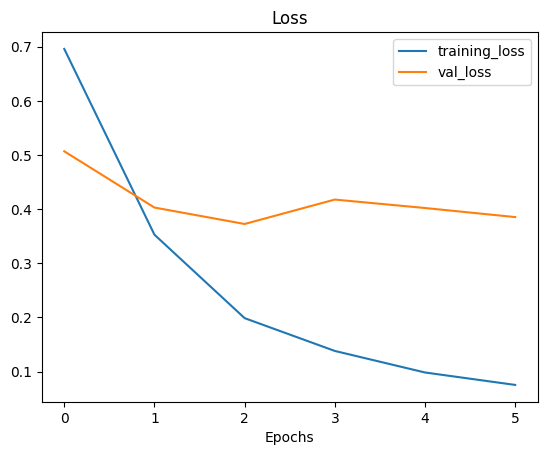

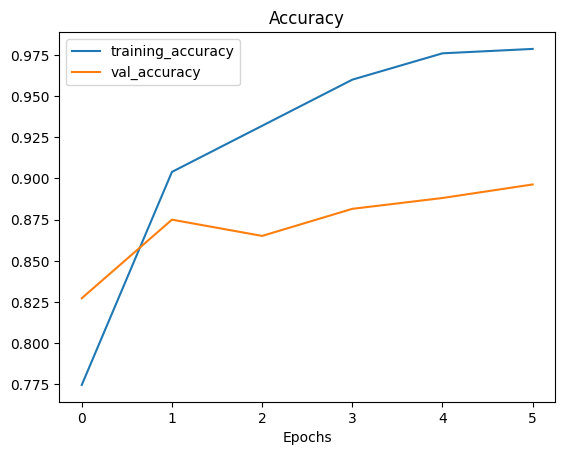

In [57]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

In [58]:
# Let's create a function to compere training histories
def compare_historys(original_history,new_history,initial_epochs=5):
  # Orijinal history ölçümleri almak
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plot for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label='Training Accuracy')
  plt.plot(total_val_acc,label='Val Accuracy')
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  # Make plot for loss 
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss,label='Training Loss')
  plt.plot(total_val_loss,label='Val Loss')
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

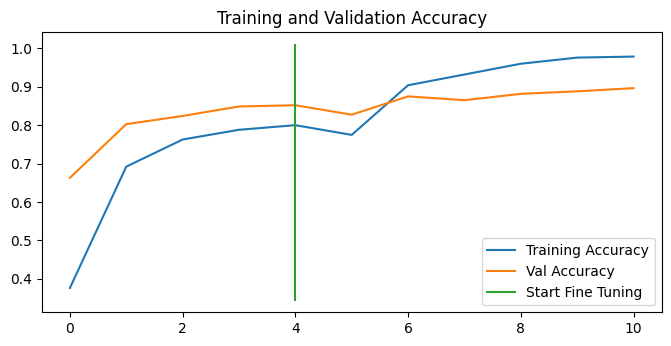

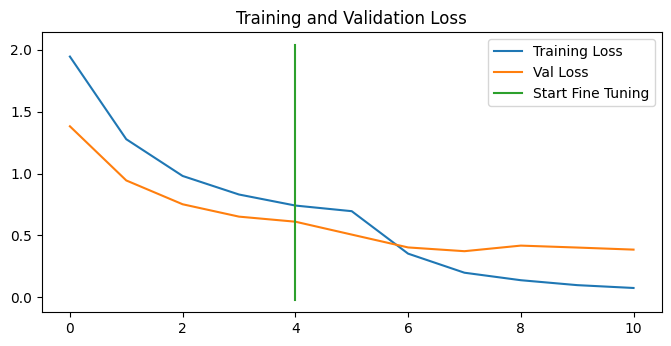

In [59]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

#### Özelik ayıklama genelikle düşük miktarda veri ile fine tunning ince ayar ise büyük miktarda veri ile daha iyi çalışır

## Model 4:Fine-tuning and existing model on all of the data

In [60]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-06-11 13:28:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 142.251.172.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   164MB/s    in 3.0s    

2023-06-11 13:28:13 (164 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [61]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [62]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 

In [63]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode='categorical',
                                                                                 image_size=IMG_SIZE)
# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [64]:
# Evaluate model 2  u model %10 train data kulanılmış fine tuning modelidir
model_2.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.4705 - accuracy: 0.8644


[0.47052621841430664, 0.8644000291824341]

In [65]:
result_fine_tune_10_percent

[0.47052621841430664, 0.8644000291824341]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights (Bir ince ayar modelini (model_4) eğitmek için model_2'yi özellik çıkarma ağırlıklarına geri döndürmemiz gerekir)

In [66]:
base_model.trainable = False
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])  

In [67]:
# Fine tuning yapabilmek için tekrardan model_2 in yani feature exractyion yaptığımız modelin ağırlıklarını yeniden yüklememiz greklidir
model_2.load_weights(checkpoint_path)

In [68]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 9s 84ms/step - loss: 0.6103 - accuracy: 0.8464


[0.6102545857429504, 0.8464000225067139]

In [69]:
# Modelimizin özelik çıkarmaya geri dönüp dönmediğini kontrol etme
results_10_percent_data_aug

[0.6102545261383057, 0.8464000225067139]

In [70]:
# Check which layers are tuneable in the whole model
for layer_number ,layer in enumerate(model_2.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 False
3 global_average_pooling_layer True
4 output_layer True


In [71]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [72]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable=True
base_model.trainable=True
# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:# son 10 katman hariç diğer katmanları dondurduk
  layer.trainable=False
# Recompile (we have recompile our models every ime we make a chenge) # Her değişiklik yaptığımızda modelerimzizi yeniden derlememiz gerekiyor
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),# ince ayar yaparken genelkle learning_rate azaltmak isteriz overfiten kaçmak için
                metrics=['accuracy'])
# base_model de günceleme yapmak otomatik olarak model_2 de de günceleme yaptığımız anlamına geliyor çünkü mode_2 bir transfer öğrenme modelidir

In [73]:
# continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback('transfer_learning','full_10_classes_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230611-132846
Epoch 5/10
235/235 [==============================] - 76s 277ms/step - loss: 0.6142 - accuracy: 0.8073 - val_loss: 0.3664 - val_accuracy: 0.8783
Epoch 6/10
235/235 [==============================] - 59s 250ms/step - loss: 0.4050 - accuracy: 0.8705 - val_loss: 0.2900 - val_accuracy: 0.9062
Epoch 7/10
235/235 [==============================] - 52s 220ms/step - loss: 0.3161 - accuracy: 0.8955 - val_loss: 0.2428 - val_accuracy: 0.9194
Epoch 8/10
235/235 [==============================] - 49s 206ms/step - loss: 0.2677 - accuracy: 0.9107 - val_loss: 0.2434 - val_accuracy: 0.9211
Epoch 9/10
235/235 [==============================] - 49s 208ms/step - loss: 0.2109 - accuracy: 0.9263 - val_loss: 0.2894 - val_accuracy: 0.9194
Epoch 10/10
235/235 [==============================] - 43s 182ms/step - loss: 0.1813 - accuracy: 0.9379 - val_loss: 0.2610 - val_accuracy: 0.9194


In [74]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 67ms/step - loss: 0.3232 - accuracy: 0.9064


[0.32317405939102173, 0.9064000248908997]

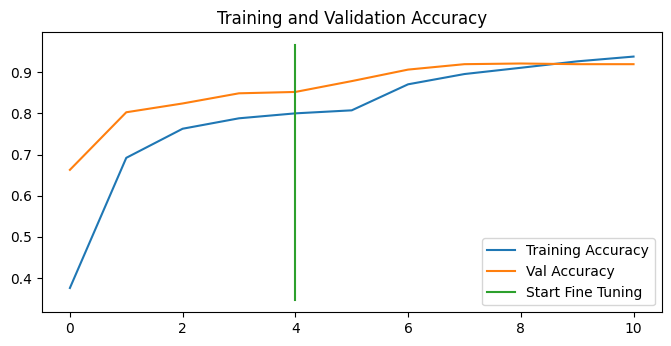

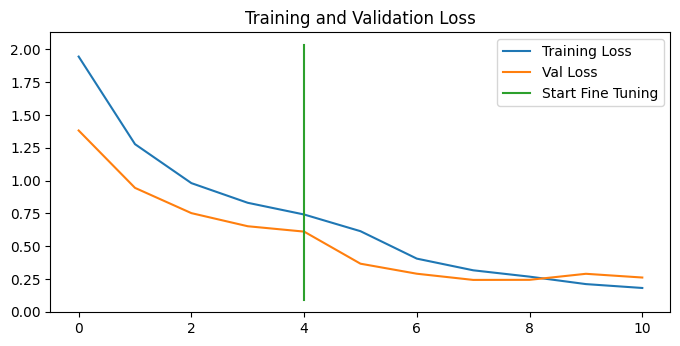

In [75]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard

Şu anda deneysel sonuçlarımız defterimizin her yerine dağılmış durumda. Bunları birisiyle paylaşmak istersek, bir sürü farklı grafik ve ölçüm elde edecekler... hiç de eğlenceli bir zaman değil. Ama tahmin et ne oldu? Yardımcı fonksiyonumuz create_tensorflow_callback() ile yaptığımız TensorBoard geri araması sayesinde, modelleme deneylerimizi her zaman takip ettik. Onları TensorBoard.dev'e yükleyip kontrol etmeye ne dersiniz? Tensorboard dev upload komutu ile bunu deneylerimizin kaydedildiği dizine geçirerek yapabiliriz. 🔑 Not: Unutmayın, TensorBoard.dev'e yüklediğiniz her şey herkese açık hale gelir. Paylaşmak istemediğiniz eğitim günlükleri varsa bunları yüklemeyin.

In [76]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished

2023-06-11 13:46:23.352292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   ZJYF-BPDW



New experiment created. View your TensorBoard at: https://tensorboard.dev/ex

In [77]:
# View previous experiments
# !tensorboard dev list# View previous experiments
!tensorboard dev list

2023-06-11 13:53:02.164540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/fzJz6FQ7T7a4aUydZSR9dQ/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   fzJz6FQ7T7a4aUydZSR9dQ
	Created              2023-06-11 13:47:21 (5 minutes ago)
	Updated              2023-06-11 13:47:26 (5 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4579477
Total: 1 experiment(s)


In [78]:
# Remove previous experiments
!tensorboard dev delete --experiment_id fzJz6FQ7T7a4aUydZSR9dQ

2023-06-11 13:53:37.899040: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment fzJz6FQ7T7a4aUydZSR9dQ.
